In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import desc, func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

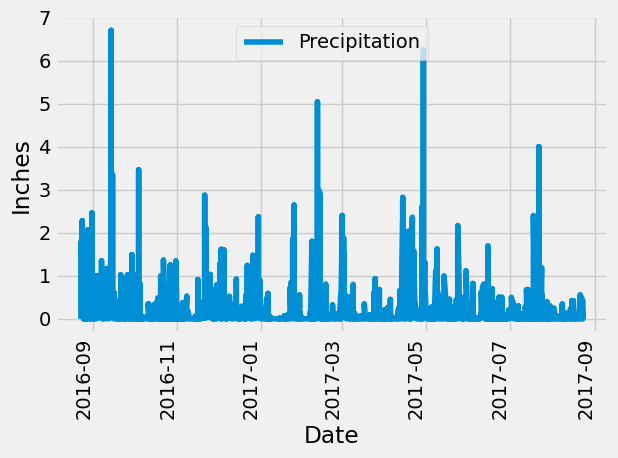

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# So, now that we know that the last date is 08/23/2017 (based on SQL above), we want to assign that to
# a variable...
last_data = dt.datetime.strptime(session.query(measurement).\
                                 order_by(measurement.date.desc()).\
                                 first().date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
year_ago = last_data - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores

# ----------------------------------------------------------------------# 
# Looks like there are two potential issues here... The first issue
# is that the precipitation was across multiple stations. I'm not certain that
# graphing the data without accounting for the multiple stations is actually
# all that useful. Would normally prefer to use an average of the
# different stations on a given date. For now, though, let's assume
# that we are going to plot as is and the sorting by date will
# take care of the required grouping.
#
# The second issue is that, from examining the data set using a SQL browser,
# There are a few rows with NA values for precipitation, so we are going to 
# need to do some data cleansing work to clean those up before we try to plot
# them.
# ----------------------------------------------------------------------# 

full_year = session.query(measurement.id,
                          measurement.station,
                          measurement.date,
                          measurement.prcp,
                          measurement.tobs).\
                            filter(measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
columns = ['ID', 'Station', 'Date', 'Precipitation', 'Temperatures']
measurements_df = pd.DataFrame(data=full_year, columns=columns)
measurements_df.set_index('ID', drop=True, inplace=True)
measurements_df = measurements_df.dropna()

# Sort the dataframe by date
measurements_df = measurements_df.sort_values(by=['Date'], ascending=True)
measurements_df['Date'] = pd.to_datetime(measurements_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data

# First, we need to down-select to just the data we need, meaning the date and the
# precipitation numbers.
precip_df = measurements_df[['Date','Precipitation']]
precip_df.set_index('Date', drop=True, inplace=True)

# Now we can use the Pandas Plotting with a couple adjustments for format...
ax = precip_df.plot(x_compat=True)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Inches")
legend = ax.legend(loc='upper center')

plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = precip_df[['Precipitation']]
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(desc(func.count(measurement.station))).\
                        all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# First, I'll create a variable called 'most frequent' that stores the most active station ID as listed above
most_frequent = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(desc(func.count(measurement.station))).\
    first()

# Then I can pass that zeroeth element from the tuple 'most_frequent' as a filter into my query to find min, max, and average
list(session.query(func.min(measurement.tobs),
                   func.max(measurement.tobs),
                   func.avg(measurement.tobs)).\
     group_by(measurement.station).\
     filter(measurement.station==most_frequent[0]))


[(54.0, 85.0, 71.66378066378067)]

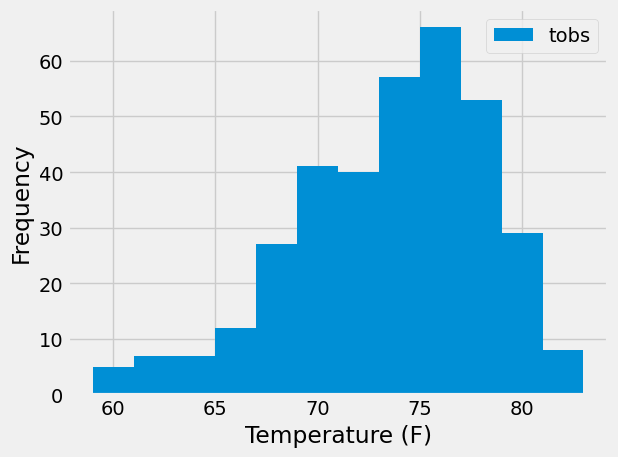

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# First step is going to be to collect the 12 months of temperature observation data into a dataframe
# using the variable created in the last cell as a filter for the data
# We can use the 'measurements_df' from earlier, and just filter it using our 'most_frequent' variable

df_filtered = measurements_df[measurements_df['Station'] == most_frequent[0]]

# That gets us the data we need to work with, so we just need to plot the histogram using pandas and matplotlib...

temp_df = df_filtered[['Date','Temperatures']]
temp_df.set_index('Date', drop=True, inplace=True)
ax = temp_df.hist(column='Temperatures', bins=12)
ax[0][0].set_ylabel('Frequency')
ax[0][0].set_xlabel('Temperature (F)')
labels= ['tobs']
plt.title('')
plt.legend(labels)
plt.tight_layout()
plt.show()



# Close Session

In [16]:
# Close Session
session.close()